In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, vectorize, stencil

np.seterr(divide="ignore", invalid="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# 4.2 Expectation Value

In [2]:
sqrt = np.sqrt
pi = np.pi
exp = np.exp

In [3]:
step = 0.5
K = 10_000
dx_rand = np.random.rand(K)
metro_rand = np.random.rand(K)
accept = np.full(K, False)
x = np.full(K, np.nan)
x[0] = 0.0

for k in range(1, K):
    init = 0.5 * x[k - 1] ** 2  # y = 0.5⋅x²
    dx = (dx_rand[k] - 0.5) * step * 2.0  # ±step
    x[k] = x[k - 1] + dx  # proposal x
    fin = 0.5 * x[k] ** 2.0  # proposal y=0.5⋅x²
    accept[k] = exp(init - fin) > metro_rand[k]  # metro test
    x[k] = x[k] if accept[k] else x[k - 1]

print(f"acceptance ratio: {accept[1:].sum() / K}")


acceptance ratio: 0.897


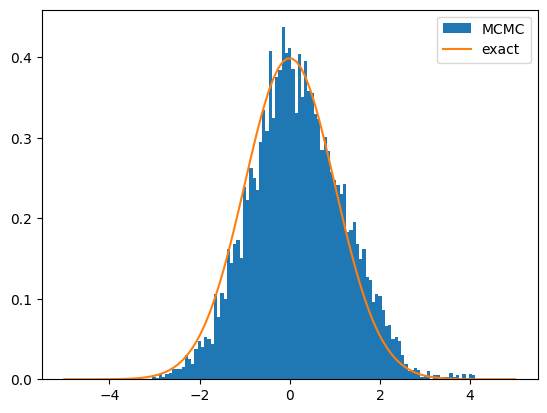

In [4]:
fig, ax = plt.subplots(1,1)
ax.hist(x, 100, density=True, label="MCMC")

x_exact = np.linspace(-5, 5, 100)
y_exact = 1 / sqrt(2 * pi) * exp(-(x_exact**2) / 2)
ax.plot(x_exact, y_exact, label="exact")

ax.legend();


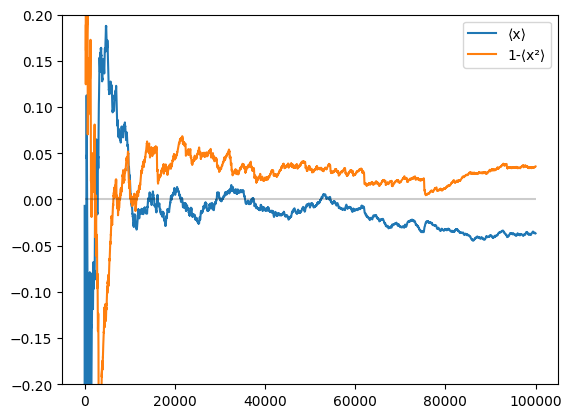

In [11]:
fig, ax = plt.subplots(1, 1)

x_1 = np.cumsum(x) / np.arange(K)
x_2 = np.cumsum(x**2) / np.arange(K)

ax.plot(x_1, label="⟨x⟩")
ax.plot(1 - x_2, label="1-⟨x²⟩")

ax.hlines(y=[0], xmin=0, xmax=K, color="black", alpha=0.2)
ax.set(ylim=[-0.2, 0.2])
ax.legend();

# numba

In [16]:
@njit
def mcmc(K=10_000, step=0.5):
    dx_rand = np.random.rand(K)
    metro_rand = np.random.rand(K)
    accept = np.full(K, False)
    x = np.full(K, np.nan)
    x[0] = 0.0

    for k in range(1, K):
        init = 0.5 * x[k - 1] ** 2  # 0.5⋅x²
        dx = (dx_rand[k] - 0.5) * step * 2.0  # ±step
        x[k] = x[k - 1] + dx  # new x
        fin = 0.5 * x[k] ** 2.0  # new 0.5⋅x²
        accept[k] = exp(init - fin) > metro_rand[k]  # metro test
        x[k] = x[k] if accept[k] else x[k - 1]

    return x, accept[1:].sum() / K


K = 100_000
x, acc = mcmc(K)


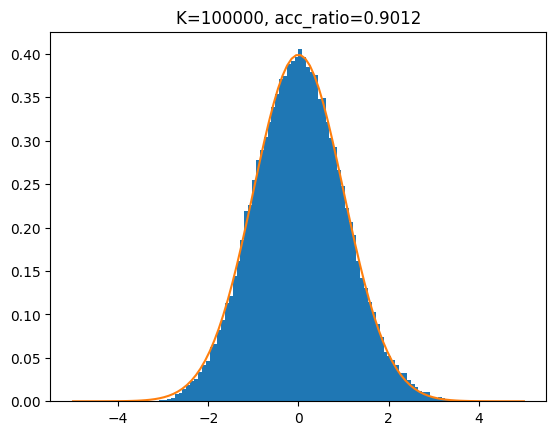

In [13]:
fig, ax = plt.subplots(1,1)
ax.set(title=f"K={K}, acc_ratio={acc}")

ax.hist(x, 100, density=True, label="MCMC")
ax.plot(x_exact, y_exact, label="exact");

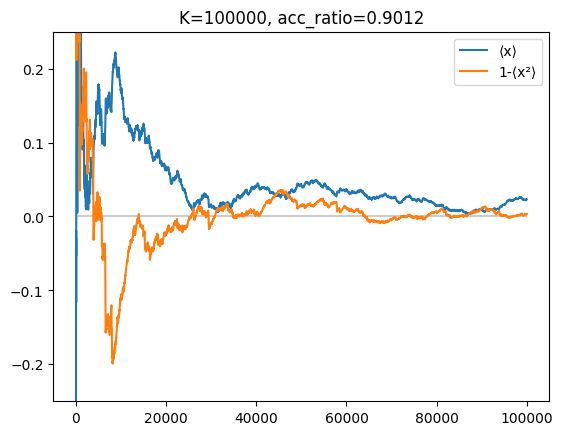

In [14]:
fig, ax = plt.subplots(1, 1)
ax.set(title=f"K={K}, acc_ratio={acc}", ylim=[-0.25, 0.25])
ax.hlines(y=[0], xmin=0, xmax=K, color="black", alpha=0.2)

x_1 = np.cumsum(x) / np.arange(K)
x_2 = np.cumsum(x**2) / np.arange(K)

ax.plot(x_1, label="⟨x⟩")
ax.plot(1 - x_2, label="1-⟨x²⟩")

ax.legend();

# steps vs acceptance ratios

In [122]:
K = 10_000
steps = np.logspace(np.log10(0.01), np.log10(20), 20)
# steps = np.linspace(0.01, 20, 20)
acc_ratios = np.full_like(steps, np.nan)
X = np.full([len(steps), K], np.nan)

for i, step in enumerate(steps):
    X[i], acc = mcmc(K=K, step=step)
    acc_ratios[i] = acc


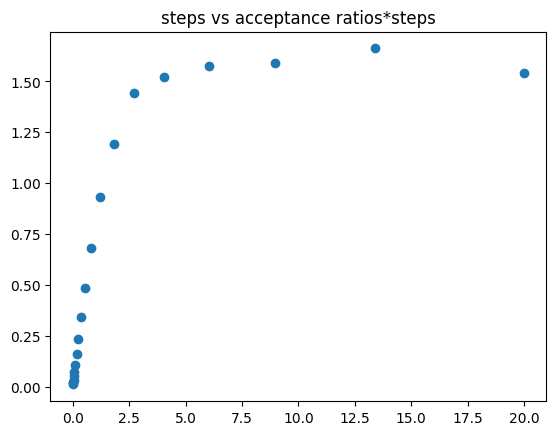

In [123]:
fig, ax = plt.subplots(1, 1)
ax.set(title="steps vs acceptance ratios*steps")

ax.scatter(steps, acc_ratios * steps)

In [124]:
X_2 = np.cumsum(X**2,axis=1) / np.arange(K)[None, :]

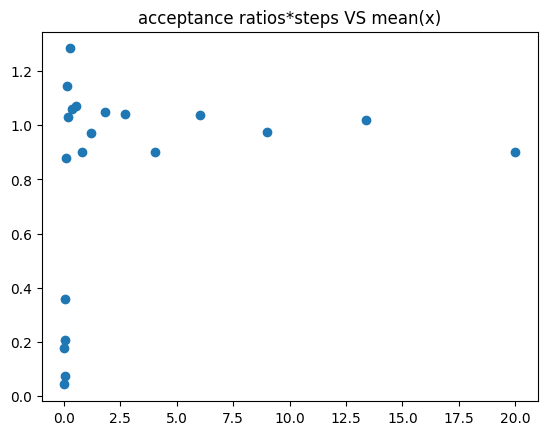

In [125]:
fig, ax = plt.subplots(1, 1)
ax.set(title="acceptance ratios*steps VS mean(x)")

ax.scatter(steps, np.nanmean(X_2, axis=1))
# ax.legend()

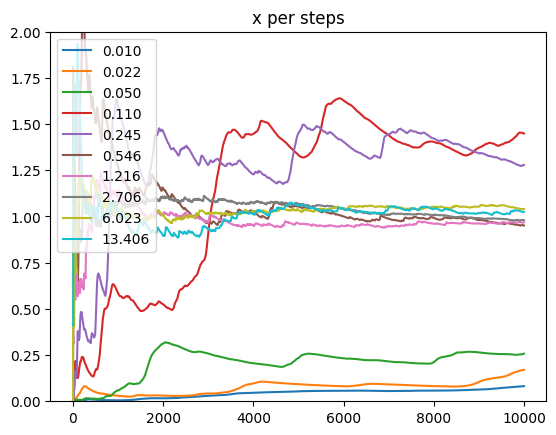

In [126]:
fig, ax = plt.subplots(1, 1)
ax.set(title="x per steps", ylim=[0, 2])

labels = [f"{x:.3f}" for x in steps][::2]
ax.plot(X_2[::2].T, label=labels)
ax.legend();